# <center>  CPU ERP Modeling </center>
---

# TL;DR
* Explore the data
* Perform feature engineering
* Build two models; Ridge Regressor and Decision Tree Regressor
* Compare the performance of the two models and pick the best one

# Meta
* Datasource : http://archive.ics.uci.edu/ml/datasets/Computer+Hardware
* CSV file URL : http://archive.ics.uci.edu/ml/machine-learning-databases/cpu-performance/machine.data
* Problem Type : Mulitvariate Regression
* Objective : Build a model to estimate ERP (Estimated Relative Performance) of a CPU 

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from math import sqrt
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz

import pydot
import warnings
from collections import Counter
from urllib.request import urlopen

warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(20,8.27)})
sns.set(font_scale=2)

### Get data from the source

In [2]:
data_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/cpu-performance/machine.data'
response = urlopen(data_url)

with open('machine.csv', 'wb') as fd:
    fd.write(response.read())

data_file = "machine.csv"
COLUMNS = ['vendor', 'model', 'myct', 'min_mm', "max_mm", 'cache', "min_ch", "max_ch", "prp", "erp"]
data = pd.read_csv(data_file, names=COLUMNS)

## Attribute Information as mentioned in the data source:

1. vendor name: 30
(adviser, amdahl,apollo, basf, bti, burroughs, c.r.d, cambex, cdc, dec,
dg, formation, four-phase, gould, honeywell, hp, ibm, ipl, magnuson,
microdata, nas, ncr, nixdorf, perkin-elmer, prime, siemens, sperry,
sratus, wang)
2. Model Name: many unique symbols
3. MYCT: machine cycle time in nanoseconds (integer)
4. MMIN: minimum main memory in kilobytes (integer)
5. MMAX: maximum main memory in kilobytes (integer)
6. CACH: cache memory in kilobytes (integer)
7. CHMIN: minimum channels in units (integer)
8. CHMAX: maximum channels in units (integer)
9. PRP: published relative performance (integer)
10. ERP: estimated relative performance from the original article (integer)

# Exploratory Analysis

In [3]:
data.describe()

,myct,min_mm,max_mm,cache,min_ch,max_ch,prp,erp
count,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000
mean,203.822967,2867.980861,11796.153110,25.205742,4.698565,18.267943,105.622010,99.330144
std,260.262926,3878.742758,11726.564377,40.628722,6.816274,25.997318,160.830733,154.757102
min,17.000000,64.000000,64.000000,0.000000,0.000000,0.000000,6.000000,15.000000
25%,50.000000,768.000000,4000.000000,0.000000,1.000000,5.000000,27.000000,28.000000
50%,110.000000,2000.000000,8000.000000,8.000000,2.000000,8.000000,50.000000,45.000000
75%,225.000000,4000.000000,16000.000000,32.000000,6.000000,24.000000,113.000000,101.000000
max,1500.000000,32000.000000,64000.000000,256.000000,52.000000,176.000000,1150.000000,1238.000000


In [4]:
data.head()

,vendor,model,myct,min_mm,max_mm,cache,min_ch,max_ch,prp,erp
0,adviser,32/60,125,256,6000,256,16,128,198,199
1,amdahl,470v/7,29,8000,32000,32,8,32,269,253
2,amdahl,470v/7a,29,8000,32000,32,8,32,220,253
3,amdahl,470v/7b,29,8000,32000,32,8,32,172,253
4,amdahl,470v/7c,29,8000,16000,32,8,16,132,132


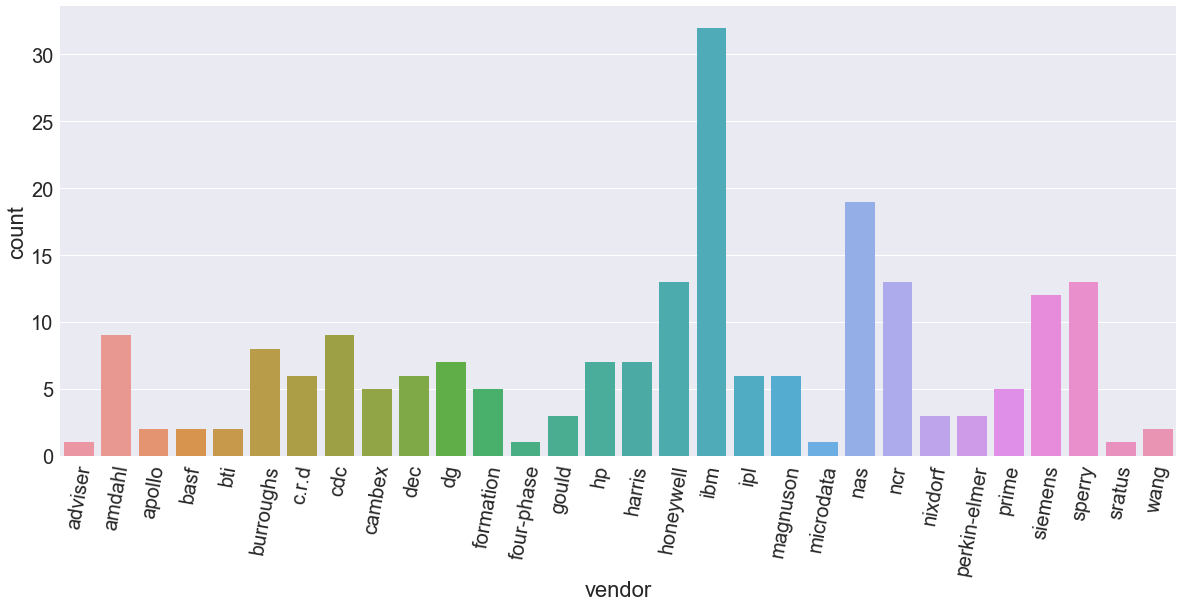

In [5]:
countplot = sns.countplot(data.vendor)
axes = countplot.set_xticklabels(countplot.get_xticklabels(), rotation=80)

## Observation
* Vendor is a categorical data, and since we are using Ridge regression, it's necessary to one-hot-encode these categorical values

In [6]:
len(data.model.unique()) / len(data)

1.0

## Observation
* Since every processor has a different model name, it is not going to be very helpful in model building. Hence, this column will be dropped

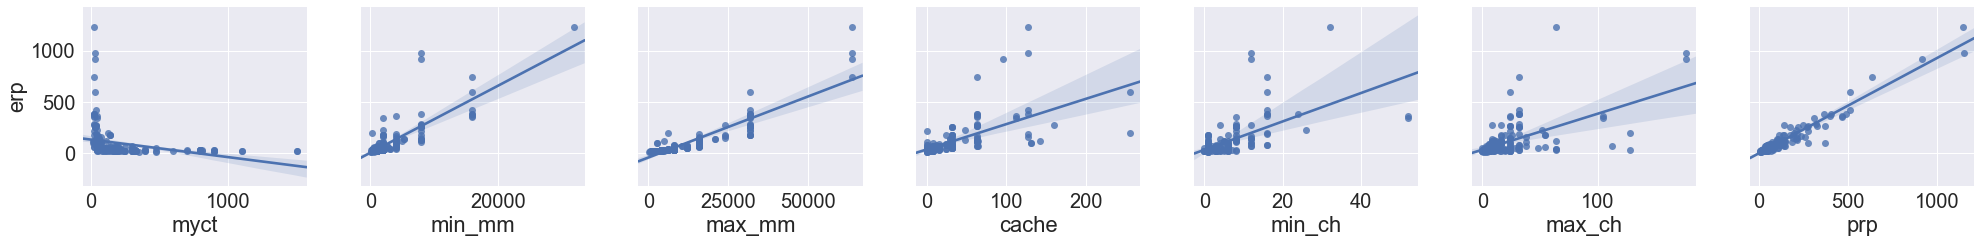

In [7]:
# Plot all continuous variables against the erp
g = sns.PairGrid(data,
                     x_vars=['myct', 'min_mm', 'max_mm', 'cache', 'min_ch', 'max_ch', 'prp'],
                     y_vars=["erp"], size=4,)
g = g.map(sns.regplot)


## Observation
* Every variable except myct seem to have an linear relationship with positive correlation with ERP
* Since myct has a very wide range and the erp values are clustered near the lower end of myct, a log transformation to myct makes sense

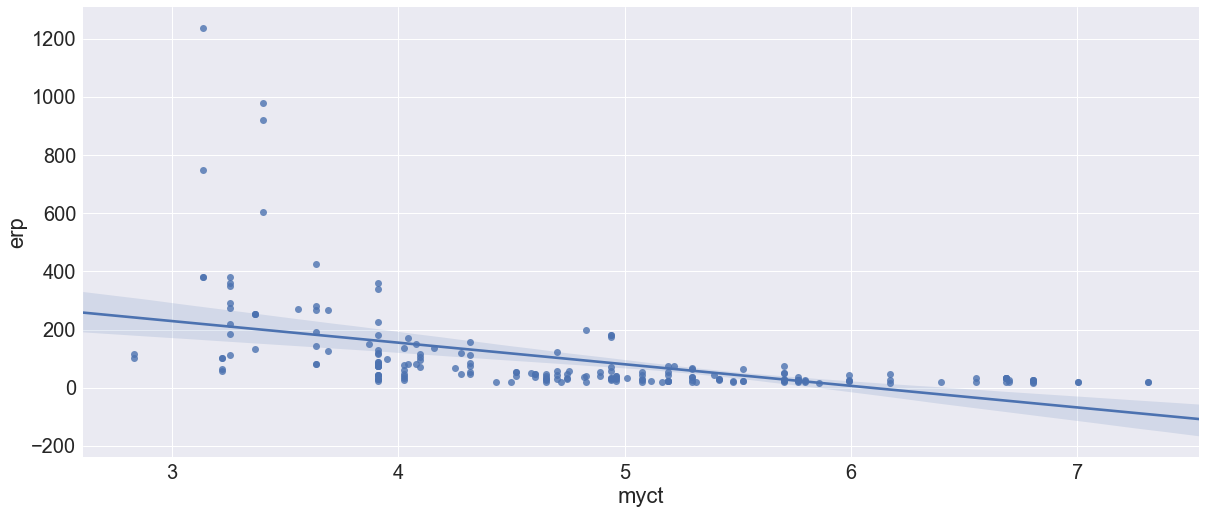

In [8]:
sns.regplot(np.log(data.myct), data.erp)

## Observation
* Log(myct) vs erp shows a downward trend with a few outliers

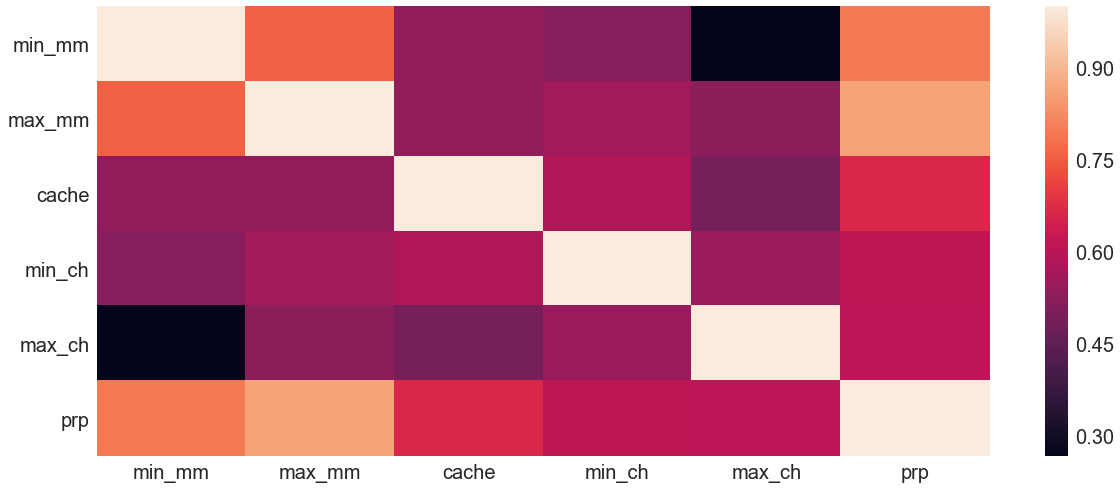

In [9]:
correlation_matrix = data[['min_mm', 'max_mm', 'cache', 'min_ch', 'max_ch', 'prp']].corr()
sns.heatmap(correlation_matrix)

## Observation
* Even though there are many correlation values greater than 0.5, prp vs max_mm stands out
* Thus, it makes sense to create a new variable prp * max_mm

In [10]:
# Prepare X and Y for training based on the observations made above
Y = data.erp

vendor_encoder = LabelBinarizer().fit(data.vendor)
X = pd.DataFrame(vendor_encoder.transform(data.vendor))
X[['min_mm', 'max_mm', 'cache', 'min_ch', 'max_ch', 'prp']] = data[['min_mm', 
                                            'max_mm', 'cache', 'min_ch', 'max_ch', 'prp']]

X['max_mm_prp'] = X['max_mm'] * X['prp']  
X['log_myct'] = np.log(data.myct)

In [11]:
def train_ridge_regressor(X, Y):
    """ Given X and Y train a Ridge regressor using Grid search and Cross validation
        Return the best model
    """
    params = {'alpha' : [0, 0.1, 1, 10]}

    model = GridSearchCV(Ridge(normalize=True, random_state=2912), param_grid=params, cv=5,  
                             scoring=make_scorer(mean_squared_error, greater_is_better=False), 
                             refit=True,
                             verbose=1, n_jobs=5)
    model.fit(X, Y)

    best_regressor = model.best_estimator_


    print("Mean squared error : ", sqrt(abs(model.best_score_)))
    return best_regressor

In [12]:
def train_tree_regressor(X, Y):
    """ Given X and Y train a decision tree regressor using Grid search and Cross validation
        Return the best model
        Create a graph(.png image) of the created tree and write to a file
    """
    params = {'max_depth' : [i for i in range(1, 30) ] + [None],
              'min_samples_split' : range(2, 15)}

    model = GridSearchCV(DecisionTreeRegressor(random_state=100), param_grid=params, cv=5,  
                             scoring=make_scorer(mean_squared_error, greater_is_better=False), 
                             refit=True,
                             verbose=1, n_jobs=5)
    model.fit(X, Y)

    best_regressor = model.best_estimator_

    # Export graph tree
    with open('treeviz.dot', 'w') as fd:
        export_graphviz(best_regressor, out_file = fd, feature_names = X.columns)

    # Create PNG image of the graph
    graph = pydot.graph_from_dot_file('treeviz.dot')[0]
    graph.write_png('tree.png')

    print("Mean squared error : ", sqrt(abs(model.best_score_)))
    return best_regressor

## Best Model using Ridge

In [13]:
best_ridge_regressor = train_ridge_regressor(X, Y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Mean squared error :  27.829743283632695


[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.1s finished


## Best Model using Decision Tree

In [14]:
best_tree_regressor = train_tree_regressor(X, Y)

Fitting 5 folds for each of 390 candidates, totalling 1950 fits


[Parallel(n_jobs=5)]: Done 1110 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 1950 out of 1950 | elapsed:    1.9s finished


Mean squared error :  76.93383420472156


## Get Feature Importance from the Tree

In [15]:
FI = pd.DataFrame({'feature' : X.columns, 'importance' : best_tree_regressor.feature_importances_})
FI

,feature,importance
0,0,0.000000e+00
1,1,0.000000e+00
2,2,0.000000e+00
3,3,0.000000e+00
4,4,0.000000e+00
5,5,0.000000e+00
6,6,0.000000e+00
7,7,0.000000e+00
8,8,6.839237e-05
9,9,0.000000e+00


# Possibilities for Improvement
* Eliminate features that are not very important
* Retrain the models using a selection of the current features

In [16]:
important_features = FI[FI.importance >= 0.002]['feature']
improved_X = X[important_features]

## Improved Ridge Regressor

In [17]:
improved_ridge_regressor = train_ridge_regressor(improved_X, Y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Mean squared error :  13.753836943228944


[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.1s finished


## Improved Tree Regressor

In [18]:
improved_tree_regressor = train_tree_regressor(improved_X, Y)

Fitting 5 folds for each of 390 candidates, totalling 1950 fits


[Parallel(n_jobs=5)]: Done 1950 out of 1950 | elapsed:    1.7s finished


Mean squared error :  76.38436794076972


## Features used

In [19]:
def get_vendor_by_id(vendor_id):
    """ Return the Vendor name given the vendor ID (which comes from one hot encoding)
    """
    vendor_encoding = [[0 for _ in range(len(data.vendor.unique()))]]
    vendor_encoding[0][vendor_id] = 1
    vendor = vendor_encoder.inverse_transform(np.array(vendor_encoding))
    return vendor[0]

In [20]:
get_vendor_by_id(3)

'basf'

In [21]:

vendor_features = [get_vendor_by_id(column) + "_yes_no" for column in X.columns if isinstance(column, int)]
other_features = [column for column in X.columns if isinstance(column, str)]

features_used = vendor_features + other_features
# Print the names of the columns that were used to build the model
features_used

['adviser_yes_no',
 'amdahl_yes_no',
 'apollo_yes_no',
 'basf_yes_no',
 'bti_yes_no',
 'burroughs_yes_no',
 'c.r.d_yes_no',
 'cambex_yes_no',
 'cdc_yes_no',
 'dec_yes_no',
 'dg_yes_no',
 'formation_yes_no',
 'four-phase_yes_no',
 'gould_yes_no',
 'harris_yes_no',
 'honeywell_yes_no',
 'hp_yes_no',
 'ibm_yes_no',
 'ipl_yes_no',
 'magnuson_yes_no',
 'microdata_yes_no',
 'nas_yes_no',
 'ncr_yes_no',
 'nixdorf_yes_no',
 'perkin-elmer_yes_no',
 'prime_yes_no',
 'siemens_yes_no',
 'sperry_yes_no',
 'sratus_yes_no',
 'wang_yes_no',
 'min_mm',
 'max_mm',
 'cache',
 'min_ch',
 'max_ch',
 'prp',
 'max_mm_prp',
 'log_myct']

# Conclusion
* Ridge regression works better than Decision tree classifier for this particular problem
* Only a select few columns(features) were useful in building the model. 
* The best model(Ridge) has a root mean squared error of 13.75

# Future Enhancement Suggestions
* Try out other models such as SVM or Neural Networks
* More feature engineering by considering the relationships among the current features
* Extract some information from the model column that was dropped in this analysis. Eg: first few characters might give us some information about the model family etc.